In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set()

In [2]:
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('W').last()

[*********************100%***********************]  9 of 9 completed


In [3]:
rets = data.pct_change().fillna(0)

<Axes: xlabel='Date'>

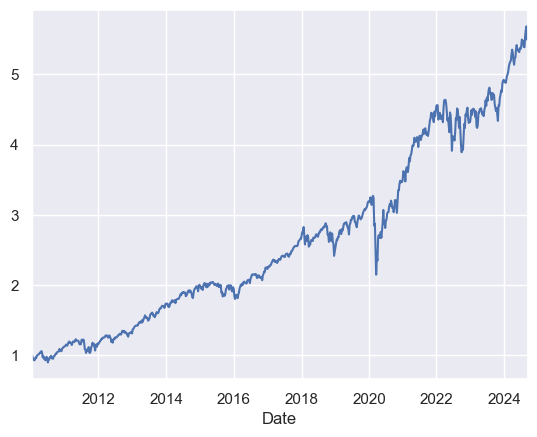

In [4]:
# EW pf return
port_rets = rets.mean(axis=1)
(1 + port_rets).cumprod().plot()

## CPPI

Portfolio insurance is an algorithm that dynamically adjusts the investment allocation based on the current portfolio's value relative to a desired lower bound, or floor, that I want to protect. As the portfolio moves further away from the floor, meaning performance improves, the investment allocation increases. Conversely, as it approaches the floor, the allocation decreases. The goal of portfolio insurance is to prevent the portfolio's value from falling below this lower bound. In this sense, the portfolio's floor acts as a stop-loss mechanism.

$$ w_{t} = \frac{M \times C_{t}}{P_{t}} $$

$$ C_{t} = P_{t} - B_{t} $$

In [5]:
#CPPI INIT
init_val = 1

# floor (stoploss : trailing stop -30%)
floor = 0.7

# leverage = 3
m = 3

# number of n = data points
n_steps = len(port_rets) # the number of for loop

A cool thing about portfolio insurance (like CPPI) is that since the portfolio's performance changes at every point in time, so do the floor level, cushion, and ultimately the investment allocation. Because of this, you can’t really use vectorized operations like you would with other methods. So, yeah, you’re kinda stuck using a for loop to implement it in an event-driven way. No shortcuts here, just gotta loop through it! 

In [9]:
# init pf value
port_value = init_val

# floor init
floor_value = init_val * floor

#peak init
peak = init_val


# make empty series
# pf value
port_history = pd.Series(dtype=np.float64).reindex_like(port_rets)
# weight
weight_history = pd.Series(dtype=np.float64).reindex_like(port_rets)
#floor history
floor_history = pd.Series(dtype=np.float64).reindex_like(port_rets)

#simulation

for step in range(n_steps): 
    peak = np.maximum(peak, port_value)
    floor_value = peak * floor
    cushion = (port_value-floor_value) / port_value
    weight = np.maximum(np.minimum(m*cushion,1),0) # 투자 비중 0~ 1 사이 값을 가지게 규제
    #m * cushion: 먼저 승수(m)와 쿠션(cushion) 값을 곱해서 투자 비중의 기본값을 계산합니다.
    #np.minimum(m * cushion, 1): 계산된 비중이 1을 초과하지 않도록 합니다. 즉, 최대 투자 비중은 100%로 제한됩니다.
    #np.maximum(..., 0): 계산된 비중이 음수가 되지 않도록 합니다. 즉, 최소 투자 비중은 0%로 설정됩니다.
    
    risky_alloc = port_value * weight
    safe_alloc = port_value * (1 - weight)
    port_value = risky_alloc * (1 + port_rets.iloc[step]) + safe_alloc


    weight_history.iloc[step] = weight
    port_history.iloc[step] = port_value
    floor_history.iloc[step] = floor_value

In [16]:
port_rets

Date
2010-01-10 00:00:00+00:00    0.000000
2010-01-17 00:00:00+00:00   -0.008478
2010-01-24 00:00:00+00:00   -0.039340
2010-01-31 00:00:00+00:00   -0.017429
2010-02-07 00:00:00+00:00   -0.006669
                               ...   
2024-08-18 00:00:00+00:00    0.029261
2024-08-25 00:00:00+00:00    0.015583
2024-09-01 00:00:00+00:00    0.009299
2024-09-08 00:00:00+00:00   -0.033101
2024-09-15 00:00:00+00:00    0.022310
Freq: W-SUN, Length: 767, dtype: float64

In [14]:
risky_alloc

2.7255580853646744

In [15]:
safe_alloc

0.5365605256743485

In [13]:
port_value

3.3229252667831357

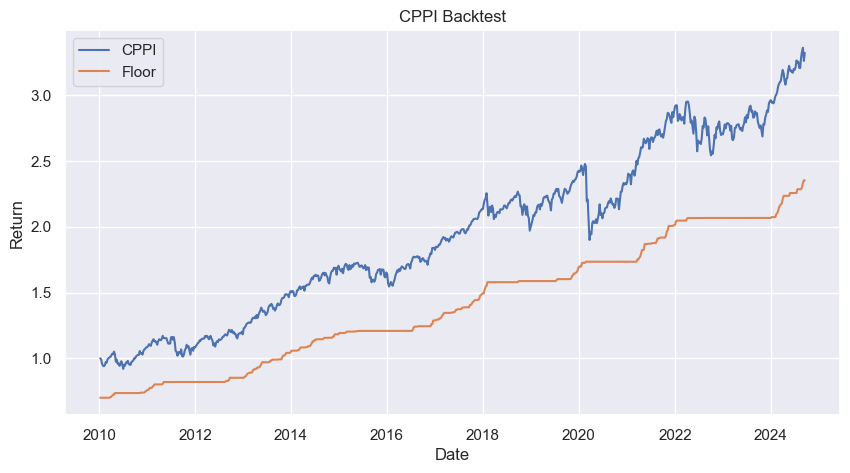

In [10]:
# 백테스팅 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(port_history, label='CPPI')
plt.plot(floor_history, label='Floor')
plt.title('CPPI Backtest')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

In [11]:
cppi_weights_df = pd.DataFrame(weight_history, index=weight_history.index, columns=['portfolio'])
cppi_weights_df['cash'] = 1 - cppi_weights_df['portfolio']

Text(0, 0.5, 'Weights')

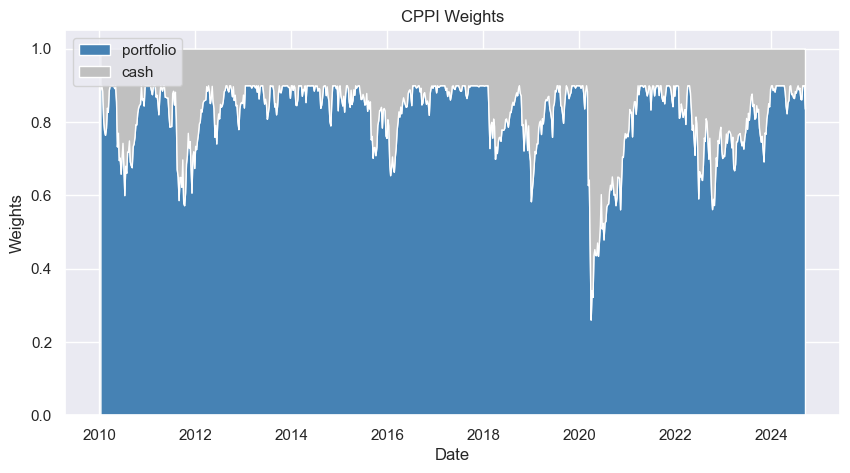

In [12]:
plt.figure(figsize=(10, 5))
plt.stackplot(cppi_weights_df.index, cppi_weights_df.T, labels=cppi_weights_df.columns, colors=['steelblue', 'silver'])
plt.legend(loc='upper left')
plt.title('CPPI Weights')
plt.xlabel('Date')
plt.ylabel('Weights')

So far, we have explored the vertical allocation model. The vertical allocation model is an algorithm designed to determine how much to invest at each point in time in a portfolio created by applying an asset universe to the horizontal allocation model. Therefore, the vertical allocation model dynamically adjusts the investment ratio between the portfolio and cash based on the chosen model. The asset universe selection, horizontal allocation model, and vertical allocation model are each essential processes required to construct our final portfolio.